In [3]:
from collections import defaultdict
import json
import os
from string import punctuation

from gensim.summarization import keywords, summarize
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from rake_nltk import Rake
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from src.data.preprocessing import CorpusPreprocess

In [26]:
def get_top_n_ngrams(matrix, vocab, ngram, n=20):
    """
    Function to get top n-grams from from document-term matrix and corresponding vocabulary
    """
    # Filter vocab to include just n-grams
    vocab = dict(filter(lambda x: len(x[0].split()) == ngram, vocab.items()))
    # Filter matrix to include just n-grams
    matrix = matrix[:, list(vocab.values())]
    # Get inverse vocab mapping: new_matrix_index -> n-gram
    inv_vocab = {i: k for i, (k, _) in enumerate(vocab.items())}
    # Get count of each n-gram
    counts = np.asarray(matrix.sum(axis=0)).flatten()
    top_ngrams = defaultdict(int)
    # Iterate over n argmax indexes of counts
    for i in reversed(counts.argsort()[-n:]):
        top_ngrams[inv_vocab[i]] = counts[i]
    return top_ngrams

# Reading the data

In [5]:
# Reading data
os.chdir("..")
INTER_PATH = os.path.join("data", "interim")
with open(os.path.join(INTER_PATH, "pdf_files.json")) as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame(
    {
        "filename": data.keys(),
        "country": [i["Country"] for i in data.values()],
        "text": [i["Text"] for i in data.values()]
    }
)

In [6]:
# Creating word count field
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [7]:
# Removing document without text
df = df.drop(df.index[df['word_count'] == 1].tolist()).reset_index(drop=True)

In [8]:
# Removing badly read documents
bad_docs = ["CreditoGanadero_Mexico", "Ley Especial Cafe_ElSalvador", "Sembrando Vida Report"]
df = df.drop(df.index[df['filename'].isin(bad_docs)].tolist()).reset_index(drop=True)

In [27]:
df.head()

,filename,country,text,word_count,prep_text
0,2019CVE 1713470_Chile,Chile,CVE 1713470|Director: Juan Jorge Lazo Rodrígue...,10401,cve director juan jorge lazo rodríguezsitio we...
1,Decreto 51_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,22442,biblioteca congreso nacional chile wwwleychile...
2,Decreto 95_Chile,Chile,www.bcn.cl - Biblioteca del Congreso Nacional ...,6058,wwwbcncl biblioteca congreso nacional chile ti...
3,Decreto8_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,1207,biblioteca congreso nacional chile wwwleychile...
4,Ley 20412_Chile,Chile,Biblioteca del Congreso Nacional de Chile - ww...,4343,biblioteca congreso nacional chile wwwleychile...


# Preprocessing the data

In [61]:
spa_stopwords = set(stopwords.words('spanish'))
extra_stopwords = {"ley", "artículo", "ser", "así", "según", "nº"}
spa_stopwords = spa_stopwords.union(extra_stopwords)

In [133]:
def remove_urls(text):
    # Remove URLs with http
    text_without_http = re.sub(r'http\S+', '', text) 
    
    # Remove URLs with only www. start
    return re.sub(r'www\S+', '', text_without_http)


def remove_dates(text):
    pass

def remove_characters(text):
    """ Remove words that are only one character (or two)"""
    pass

In [87]:
# Experiment: Using a stanza pipeline
import stanza 

In [88]:
stanza.download("es")

2020-10-29 01:49:39 INFO: Downloading default packages for language: es (Spanish)...
2020-10-29 02:01:17 INFO: Finished downloading models and saved to /Users/dafirebanks/stanza_resources.


In [89]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2020-10-29 02:01:26 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2020-10-29 02:01:26 INFO: Use device: cpu
2020-10-29 02:01:26 INFO: Loading: tokenize
2020-10-29 02:01:26 INFO: Loading: mwt
2020-10-29 02:01:26 INFO: Loading: pos
2020-10-29 02:01:27 INFO: Loading: lemma
2020-10-29 02:01:27 INFO: Done loading processors!


In [129]:
sample_text = df.loc[1, "text"]
sample_text = remove_urls(sample_text)

In [131]:
lemmatize_pipeline = stanza.Pipeline(lang='es', processors='tokenize, lemma')

def lemmatize_text(text):
    lemmatized_text = lemmatize_pipeline(text)
    return " ".join([word.lemma for sentence in lemmatized_text.sentences for word in sentence.words])

2020-10-29 02:19:57 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| lemma     | ancora  |

2020-10-29 02:19:57 INFO: Use device: cpu
2020-10-29 02:19:57 INFO: Loading: tokenize
2020-10-29 02:19:57 INFO: Loading: lemma
2020-10-29 02:19:57 INFO: Done loading processors!


In [132]:
lemmatize_text(sample_text)

'Biblioteca del Congreso Nacional de Chile - - documento generar el 22-Dic-2016 tipo Norma : Decreto 51 fecho publicación : 14-04-2012 fecho promulgación : 24-10-2011 organismo : ministerio de agricultura título : fija reglamento de el ley yo 20412 que establece uno sistemo de incentivo para el sustentabilidad agroambiental de el suelo agropecuario tipo versión : último versión de : 07-11-2015 inicio vigencia : 07-11-2015 id Norma : 1038989 ultimo modificación :ú7-nov-2015 Decreto 18 url : reglamento de el ley yo 20412 que establece unsistema de incentivo para el sustentabilidad agroambientalde el suelo agropecuario núm/100 . 51 . - Santiago , 24 de octubre de 2011 .- visto : lodispuesto en el dfl yo 294 , de 1960 , del Ministerio dehaciendo , Orgánico del Ministerio de Agricultura ; el leyno 20412 , que establecer uno Sistema de incentivo para laSustentabilidad agroambiental de el suelo Agropecuarios;el dfl yo 1199653 , del Ministerio Secretaría General delo Presidencia , que fijar el

In [134]:
df["pre_pretext"] = df["text"].apply(lambda x: remove_urls(x))

In [136]:
df["pre_pretext"] = df["pre_pretext"].apply(lambda x: lemmatize_text(x))

In [100]:
prep = CorpusPreprocess(
    language='spanish', 
    stop_words=spa_stopwords,
    lowercase=True,
    strip_accents=True,
    strip_numbers=True,
    strip_punctuation=punctuation,
    stemmer=SnowballStemmer('spanish'), 
    max_df=0.9, 
    min_df=2
)

df["prep_text"] = prep.fit_transform(df['text'], tokenize=False)

# Word count for each document

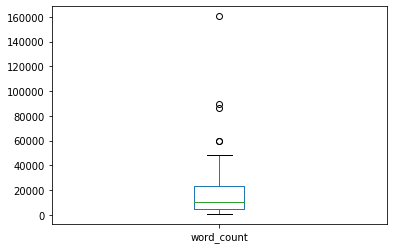

In [101]:
# Fetch word count for each document
df['word_count'].plot(kind='box')
plt.show()

In [102]:
# Describe word count
df['word_count'].describe()

count        53.000000
mean      19574.735849
std       27808.945196
min         649.000000
25%        4752.000000
50%       10222.000000
75%       23025.000000
max      160442.000000
Name: word_count, dtype: float64

Should we weight each document? Otherwise we could find keywords that do not represent each document in the same way.

# Bag-of-Words

In [103]:
# Count Vectorizer
cv = CountVectorizer(max_features=20000, ngram_range=(1,3))
bow_X = cv.fit_transform(df['prep_text'])

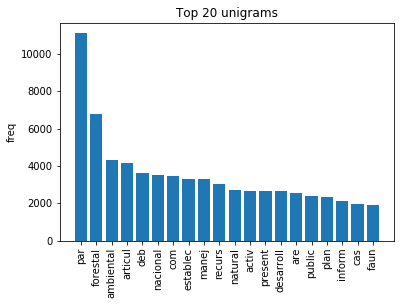

In [104]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

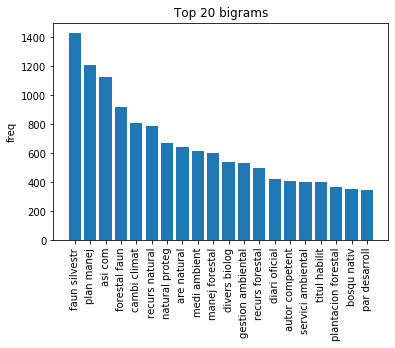

In [105]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

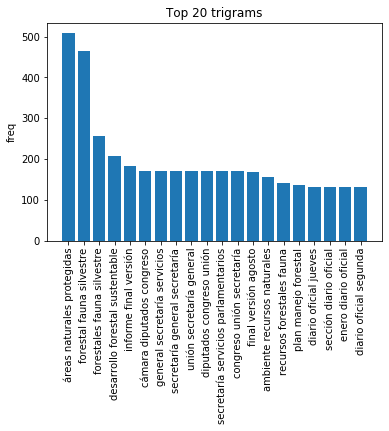

In [68]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(bow_X, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

In [69]:
top_trigrams

defaultdict(int,
            {'áreas naturales protegidas': 508,
             'forestal fauna silvestre': 465,
             'forestales fauna silvestre': 256,
             'desarrollo forestal sustentable': 208,
             'informe final versión': 183,
             'cámara diputados congreso': 171,
             'general secretaría servicios': 171,
             'secretaría general secretaría': 171,
             'unión secretaría general': 171,
             'diputados congreso unión': 171,
             'secretaría servicios parlamentarios': 171,
             'congreso unión secretaría': 171,
             'final versión agosto': 167,
             'ambiente recursos naturales': 156,
             'recursos forestales fauna': 142,
             'plan manejo forestal': 137,
             'diario oficial jueves': 131,
             'sección diario oficial': 131,
             'enero diario oficial': 131,
             'diario oficial segunda': 131})

## What if we want to normalize by word counts?

In [70]:
bow_X_norm = bow_X / bow_X.sum(axis=1)

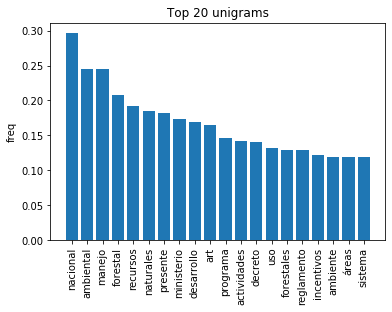

In [71]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

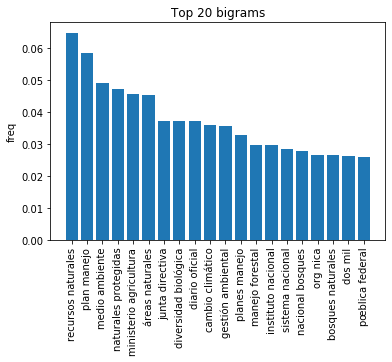

In [72]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

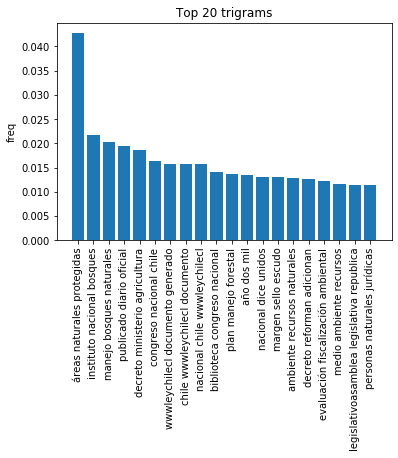

In [73]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(bow_X_norm, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

In [74]:
top_trigrams

defaultdict(int,
            {'áreas naturales protegidas': 0.04276502358052167,
             'instituto nacional bosques': 0.021740010490798167,
             'manejo bosques naturales': 0.020218069479404147,
             'publicado diario oficial': 0.01943170067552216,
             'decreto ministerio agricultura': 0.018612427832585862,
             'congreso nacional chile': 0.016451424460466577,
             'wwwleychilecl documento generado': 0.015645622687702677,
             'chile wwwleychilecl documento': 0.015645622687702677,
             'nacional chile wwwleychilecl': 0.015645622687702677,
             'biblioteca congreso nacional': 0.014110879990911106,
             'plan manejo forestal': 0.013685376942560733,
             'año dos mil': 0.013450469185071305,
             'nacional dice unidos': 0.013004893697203862,
             'margen sello escudo': 0.013004893697203862,
             'ambiente recursos naturales': 0.012872631697887276,
             'decreto reforman ad

# TF-IDF

In [75]:
# Count Vectorizer
tv = TfidfVectorizer(max_features=20000, ngram_range=(1,3))
tfidf_X = tv.fit_transform(df['prep_text'])

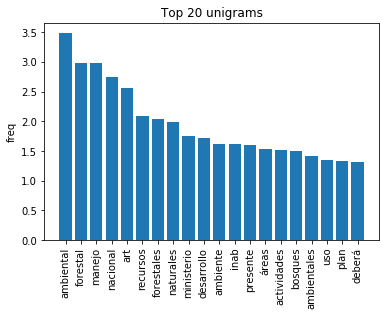

In [76]:
# Get top uni-grams
top_unigrams = get_top_n_ngrams(tfidf_X, tv.vocabulary_, 1, 20)

plt.bar(top_unigrams.keys(), top_unigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 unigrams')
plt.show()

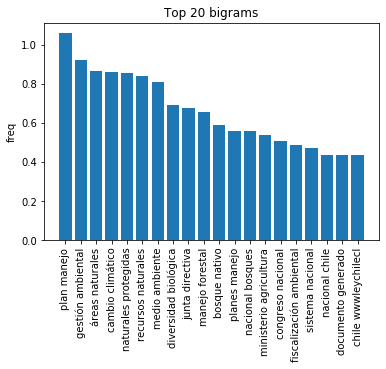

In [77]:
# Get top bi-grams
top_bigrams = get_top_n_ngrams(tfidf_X, cv.vocabulary_, 2, 20)

plt.bar(top_bigrams.keys(), top_bigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 bigrams')
plt.show()

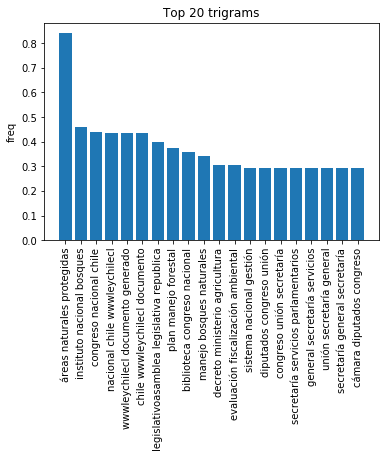

In [78]:
# Get top tri-grams
top_trigrams = get_top_n_ngrams(tfidf_X, cv.vocabulary_, 3, 20)

plt.bar(top_trigrams.keys(), top_trigrams.values())
plt.xticks(rotation=90)
plt.ylabel('freq')
plt.title('Top 20 trigrams')
plt.show()

# Can we see keywords for single document?

In [24]:
print(df.loc[40, "text"][:1000],"...")

print('\nGet top uni-grams bow:')
for k, v in get_top_n_ngrams(bow_X[40], cv.vocabulary_, 1, 10).items():
    print(f"\"{k}\" count: {round(v,3)}")
    
print('\nGet top uni-grams tfidf:')
for k, v in get_top_n_ngrams(tfidf_X[40], tv.vocabulary_, 1, 10).items():
    print(f"\"{k}\" count: {round(v,3)}")

Aprueban Reglamento de la Ley Nº 28245, Ley Marco del Sistema Nacional de Gestión Ambiental DECRETO SUPREMO Nº 008-2005-PCM       EL PRESIDENTE DE LA REPÚBLICA      CONSIDERANDO:      Que, el artículo 67 de la Constitución Política del Perú, el Estado determina la política nacional del ambiente y promueve el uso sostenible de los recursos naturales;      Que, mediante Ley Nº 28245, Ley Marco del Sistema Nacional de Gestión Ambiental, se regula el Sistema Nacional de Gestión Ambiental, el cual tiene como finalidad orientar, integrar, coordinar, supervisar, evaluar y garantizar la aplicación de las políticas, planes, programas y acciones destinados a la protección del ambiente y contribuir a la conservación y aprovechamiento sostenible de los recursos naturales;      Que, la Segunda Disposición Complementaria de la referida Ley establece que el Poder Ejecutivo en un plazo de noventa (90) días calendario, contados a partir de la fecha de vigencia de la Ley, aprobará mediante Decreto Supre

# Word cloud

## BOW

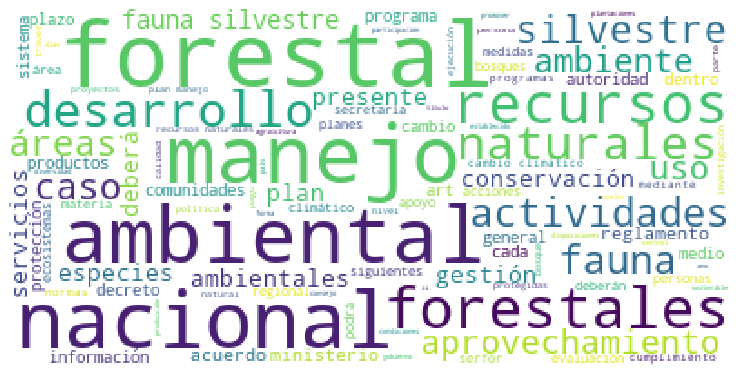

In [79]:
sorted_vocab = {k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(bow_X.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

## BOW normalized

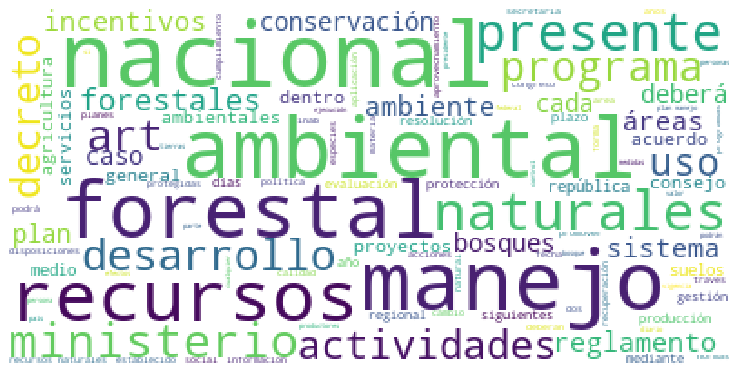

In [80]:
sorted_vocab = {k: v for k, v in sorted(cv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(bow_X_norm.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

## TF-IDF

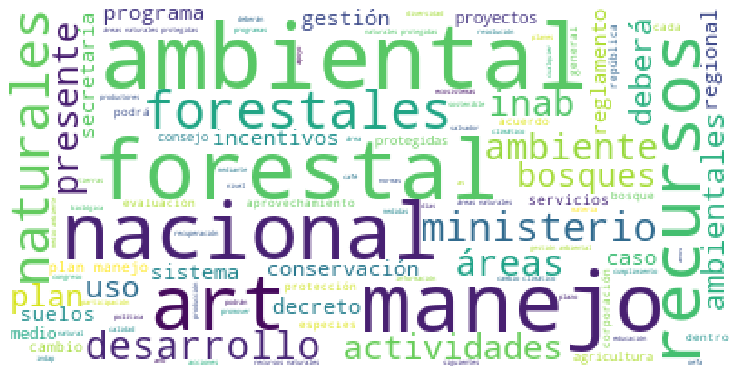

In [81]:
sorted_vocab = {k: v for k, v in sorted(tv.vocabulary_.items(), key=lambda item: item[1])}
frequencies = np.asarray(tfidf_X.sum(axis=0)).flatten()
word_freq = {k:v for k, v in zip(sorted_vocab.keys(), frequencies)}

wordcloud = WordCloud(
    background_color='white',
    max_words=100,
    max_font_size=50, 
    random_state=42
).generate_from_frequencies(word_freq)

fig = plt.figure(figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
# fig.savefig("word1.png", dpi=900)

# Keyword extraction algorithms

## Preprocessing (keep sentence structure)

In [82]:
sentences = df['text'].apply(lambda x: sent_tokenize(x, language='spanish')).explode()
sentences

0     CVE 1713470|Director: Juan Jorge Lazo Rodrígue...
0     Para verificar la autenticidad de una represen...
0     42.558|Martes 21 de Enero de 2020|Página 1 de ...
0     24.- Santiago, 17 de octubre de 2019.€Visto:€L...
0     Fíjase la siguiente Tabla de Costos que establ...
                            ...                        
51    Luego de dicha fecha carecerá de valor.5.7 El ...
51    Para determinar el valor a otorgar se tomará e...
51    Dicha solicitud deberá presentarse hasta el úl...
52    605094NORMAS LEGALESViernes 25 de noviembre de...
52    Asimismo, la referida sesión servirá para que ...
Name: text, Length: 30823, dtype: object

In [83]:
# Word count per sentence
sentences.str.split().apply(lambda x: len(x)).describe()

count    30823.000000
mean        32.027382
std         46.851828
min          1.000000
25%          9.000000
50%         22.000000
75%         39.000000
max       1894.000000
Name: text, dtype: float64

In [84]:
prep = CorpusPreprocess(
    language='spanish', 
    stop_words=spa_stopwords,
    lowercase=True,
    strip_accents=True,
    strip_numbers=True,
    strip_punctuation=punctuation,
#   stemmer=SnowballStemmer('spanish'), 
    max_df=0.9, 
    min_df=2
)

sentences_prep = pd.Series(prep.fit_transform(sentences, tokenize=False), index=sentences.index)

/Users/dafirebanks/miniconda3/envs/dsci/lib/python3.7/site-packages/bs4/__init__.py:336: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [85]:
sentences_prep

0     cve director juan jorge lazo rodríguezsitio we...
0     verificar autenticidad representación impresa ...
0     martes enero página normas generalescve minist...
0     santiago octubre €visto€lo dispuesto constituc...
0     fíjase siguiente tabla costos establece año va...
                            ...                        
51    luego dicha fecha carecerá valor puntaje obten...
51    determinar valor otorgar tomará cuenta inversi...
51    dicha solicitud deberá presentarse último día ...
52    normas legalesviernes noviembre peruanopoder l...
52    asimismo referida sesión servirá delegaciones ...
Length: 30823, dtype: object

# Rake and TextRank

In [86]:
for ix in sentences_prep.index.unique():
    # RAKE
    rake = Rake(language="spanish")
    rake.extract_keywords_from_sentences(sentences_prep[ix])
    rake_out = rake.get_ranked_phrases()
    print("\nRAKE OUTPUT:\n> ", "\n> ".join(rake_out[:10]))
    
    # TextRankV1
    textrankv1_out = keywords(" ".join(sentences_prep[ix]), split=True)
    print("\nTEXTRANKV1 OUTPUT:\n> ", "\n> ".join(textrankv1_out[:10]))
    
    # TextRankV2
    textrankv2_out = summarize(". ".join(sentences_prep[ix]), split=True)
    print("\nTEXTRANKV2 OUTPUT:\n> ", "\n> ".join(textrankv2_out[:10]))
    break


RAKE OUTPUT:
>  entiende porguano subproductos ganadería incluye excrementos animales material camatransformado posible identificar composición cama lasdeyecciones debido alto nivel fermentaciónen relación almacenamiento transporte aplicación guano deberán respetarselos criterios manejo guano establecidos documento vigente ﬁpauta técnica laaplicación guanoﬂ elaborado división recursos naturales renovables servicioagrícola ganaderoademás deberá demostrar aplicación guano producirá contaminación pornitrógeno cálculo dosis guano aplicar deberá fundamentado através metodología propuesta documento mencionadolo señalado párrafo anterior aplicará regiones arica parinacota detarapacá antofagasta atacama dado características edafoclimáticas comosus sistemas productivos rendimientos promedios obtenidos permiten utilización dela metodología propuesta dicho documento
> establece sistema incentivos sustentabilidadagroambiental suelos agropecuarios cuyos objetivos recuperación potencialproductivo s

# Look into 
https://boudinfl.github.io/pke/build/html/index.html